In [ ]:
!pip install kaggle

In [ ]:
!mkdir .kaggle

In [ ]:
import json
token = {"username":"mandavagnaneshwar","key":"ed4ddd78a3cb2d3664a04368004f2925"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [ ]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

  0% 0.00/13.1k [00:00<?, ?B/s]
100% 13.1k/13.1k [00:00<00:00, 22.3MB/s]
  0% 0.00/31.2k [00:00<?, ?B/s]
100% 31.2k/31.2k [00:00<00:00, 32.3MB/s]
  0% 0.00/450k [00:00<?, ?B/s]
100% 450k/450k [00:00<00:00, 63.5MB/s]
  0% 0.00/441k [00:00<?, ?B/s]
100% 441k/441k [00:00<00:00, 62.7MB/s]


In [ ]:
!pip install feature_engine

     |████████████████████████████████| 9.5MB 17.8MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as snb
import scipy.stats as stats
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


from feature_engine.missing_data_imputers import MeanMedianImputer, CategoricalVariableImputer, AddMissingIndicator
from feature_engine.categorical_encoders import OneHotCategoricalEncoder, RareLabelCategoricalEncoder,OrdinalCategoricalEncoder
from feature_engine.outlier_removers import OutlierTrimmer
from feature_engine import variable_transformers
from feature_engine.discretisers import EqualWidthDiscretiser
import seaborn as sns
sns.set_style('whitegrid')

import warnings  
warnings.filterwarnings('ignore')

In [ ]:
train = pd.read_csv('/content/{/content}/competitions/house-prices-advanced-regression-techniques/train.csv')

In [ ]:
test = pd.read_csv('/content/{/content}/competitions/house-prices-advanced-regression-techniques/test.csv')

Skewness Co-efficient: 1.883


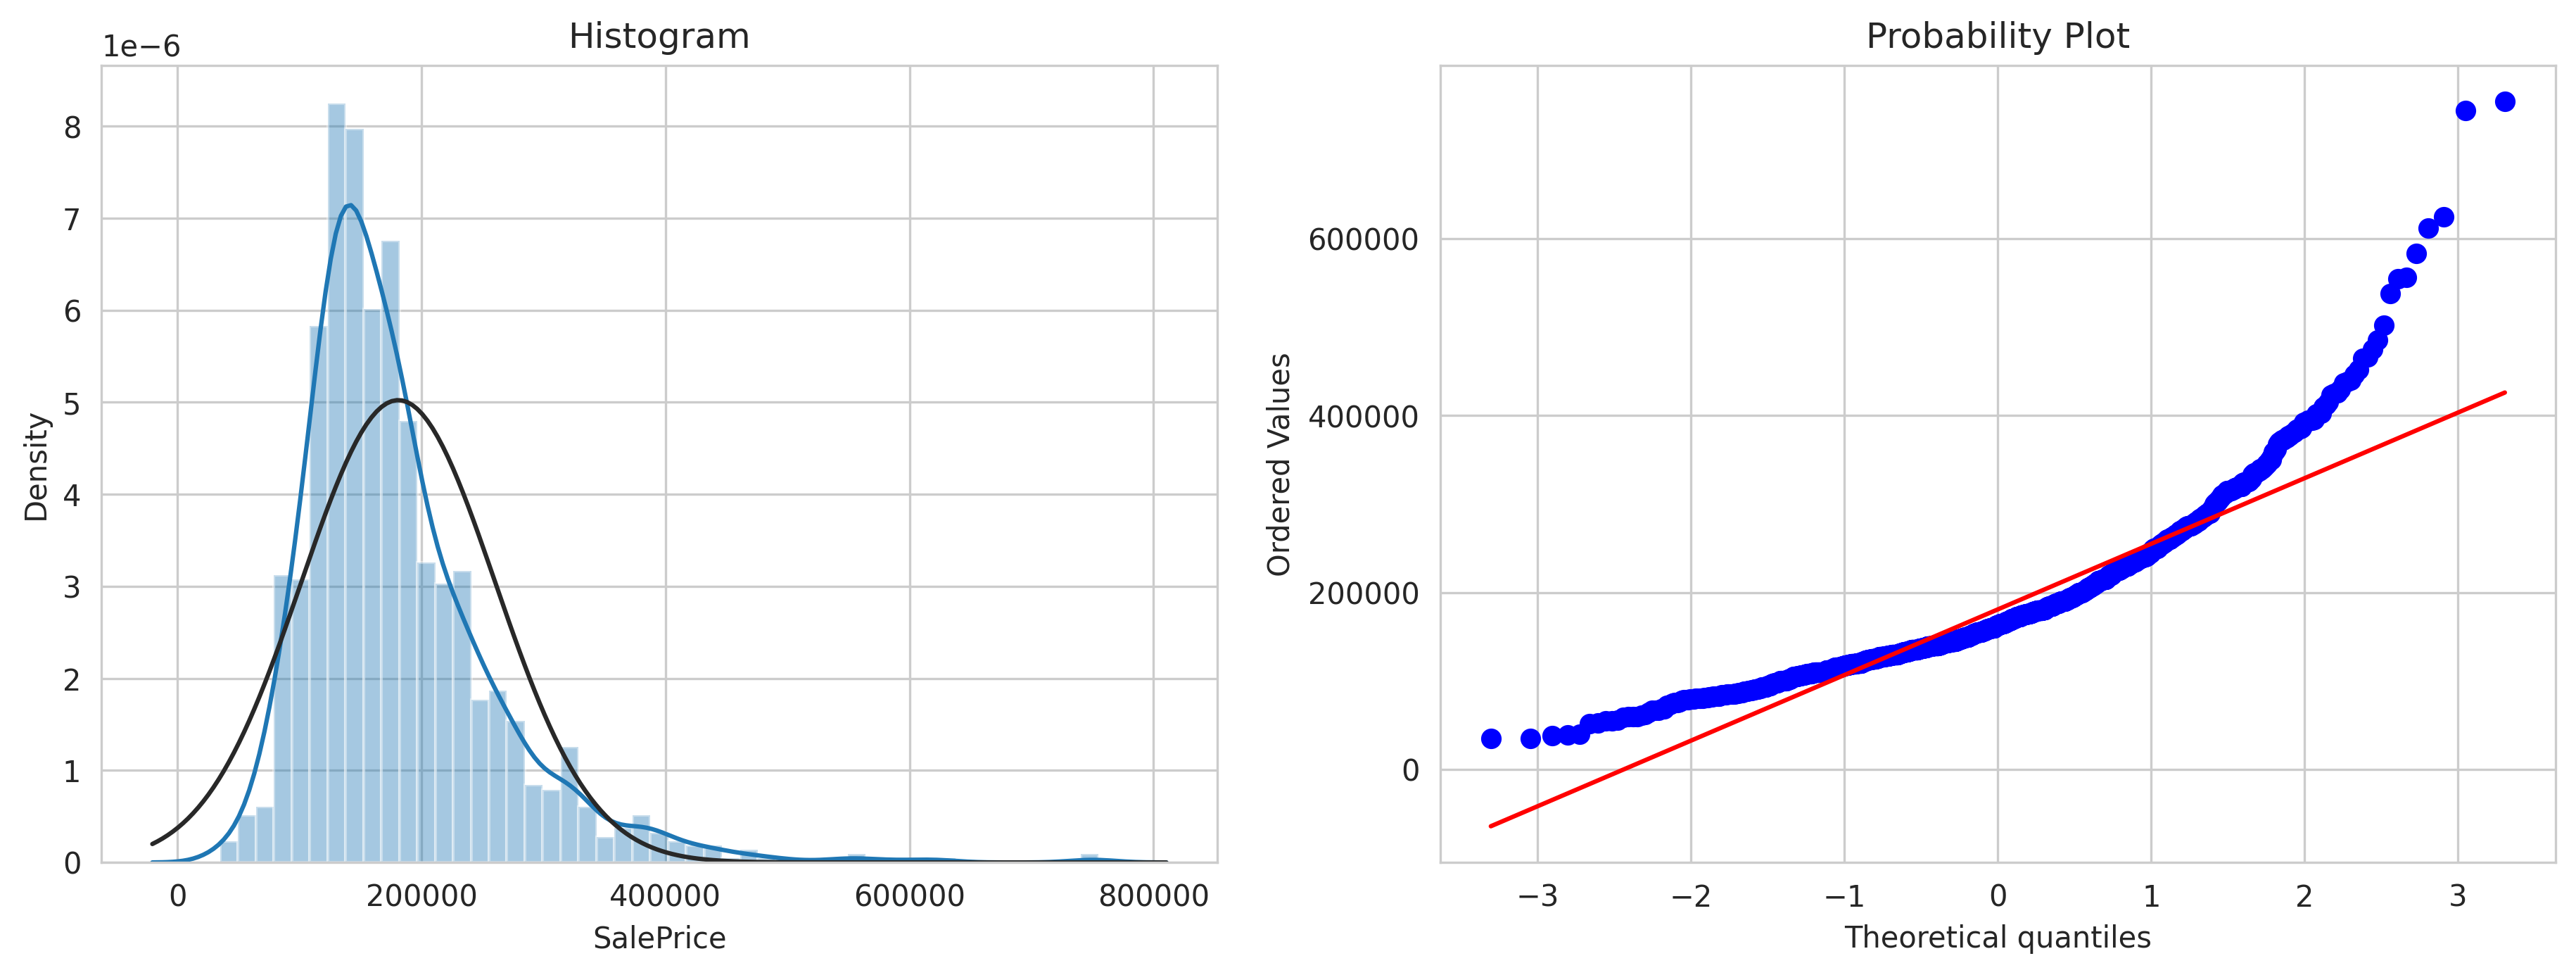

In [ ]:
##### GET SKEWNESS #####
print(f"Skewness Co-efficient: {round(train.SalePrice.skew(), 3)}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=300)

##### HISTOGRAM #####
from scipy import stats
sns.distplot(train['SalePrice'] , fit=stats.norm, ax=ax1)
ax1.set_title('Histogram')

##### PROBABILITY / QQ PLOT #####
stats.probplot(train['SalePrice'], plot=ax2)

plt.show()



Skewness Co-efficient: 0.121


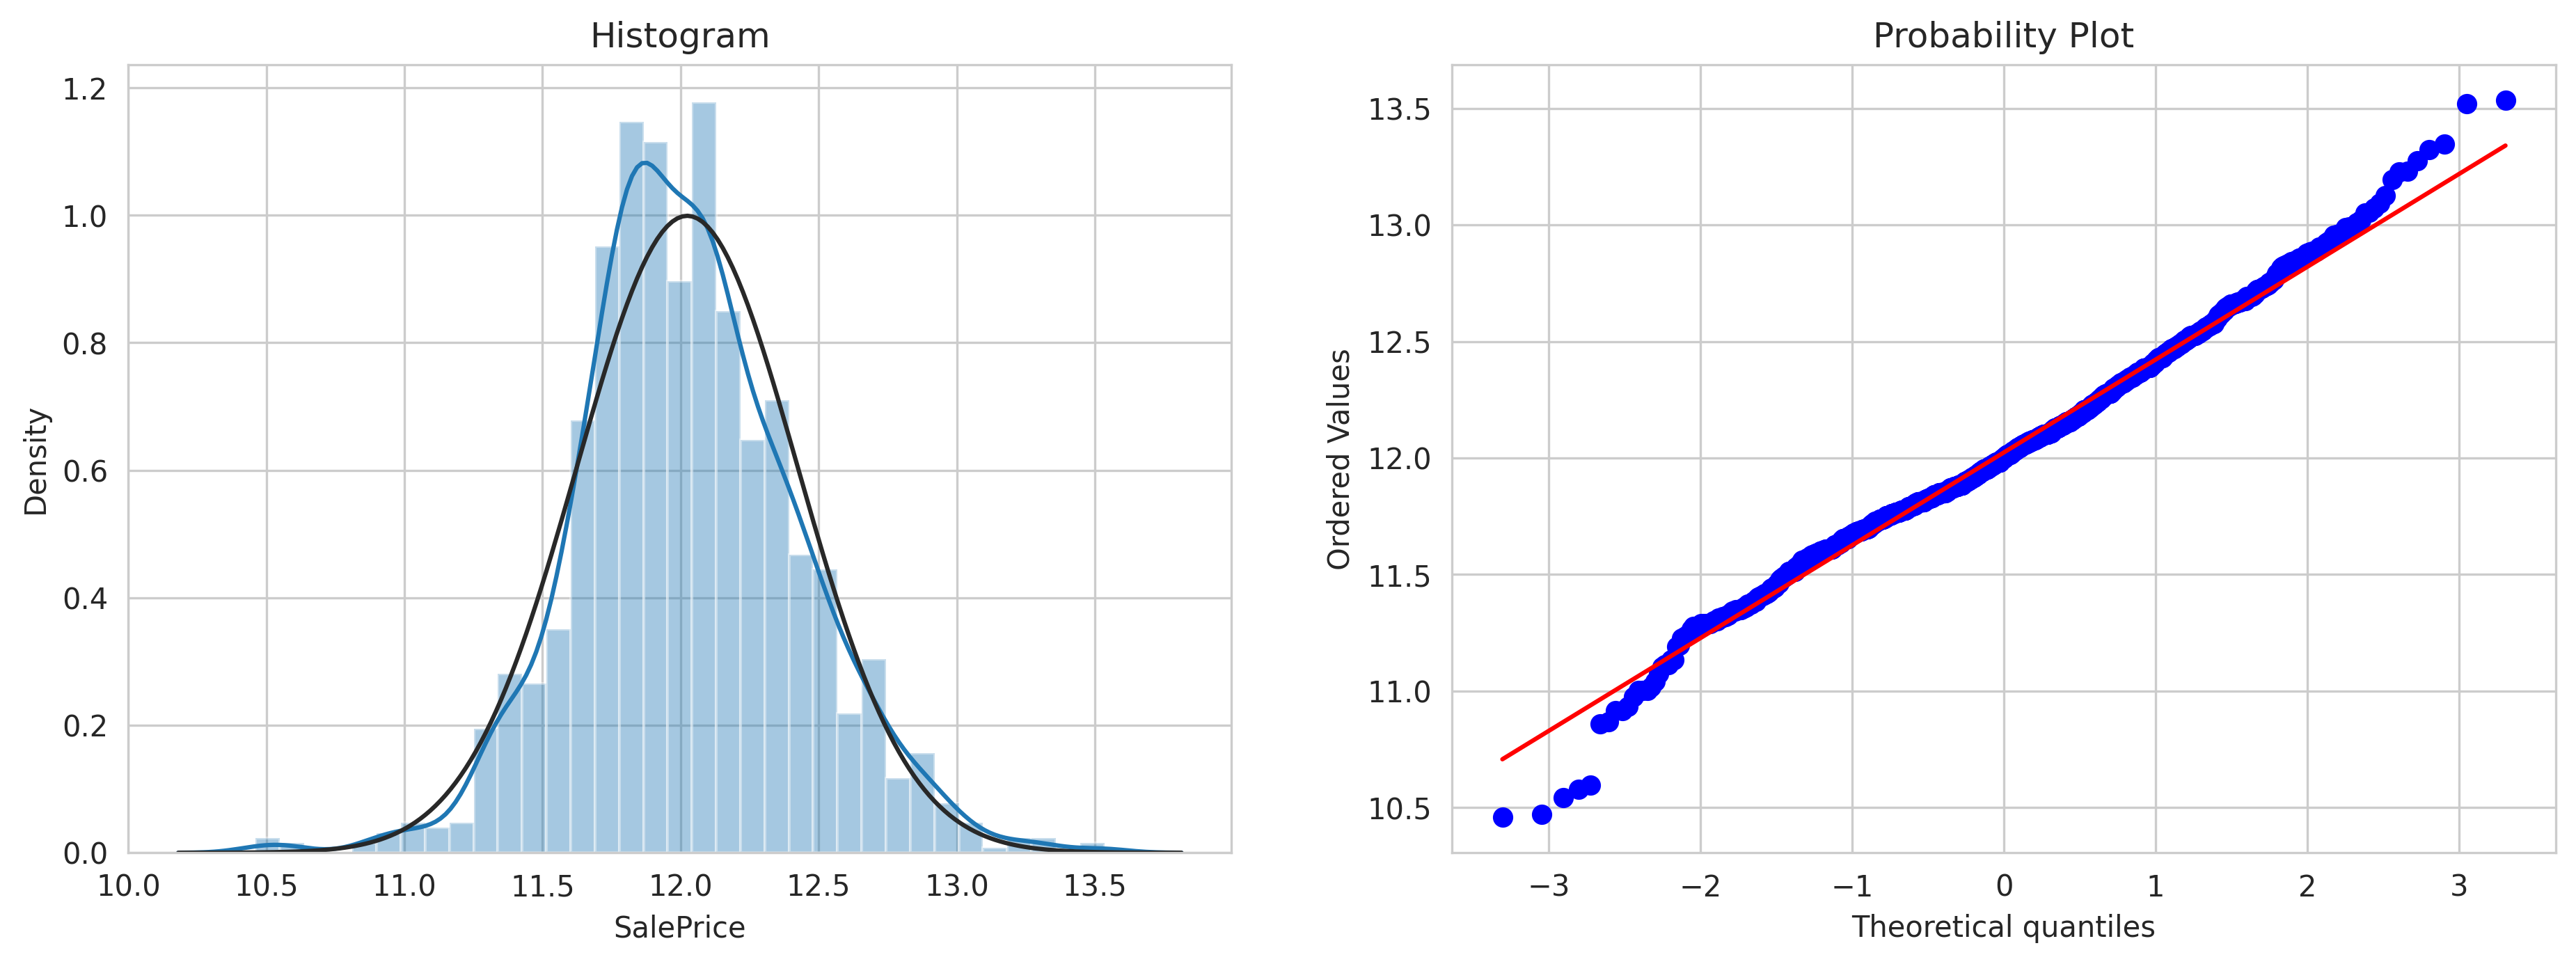

In [ ]:
train["SalePrice"] = np.log1p(train["SalePrice"])

##### GET SKEWNESS #####
print(f"Skewness Co-efficient: {round(train.SalePrice.skew(), 3)}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=300)

##### HISTOGRAM #####
from scipy import stats
sns.distplot(train['SalePrice'] , fit=stats.norm, ax=ax1)
ax1.set_title('Histogram')

##### PROBABILITY / QQ PLOT #####
stats.probplot(train['SalePrice'], plot=ax2)

plt.show()

In [ ]:
'''
    Store the number of rows or indexes for train and test dataset
    to separate them while performing modeling and prediction.
'''
ntrain = train.shape[0]
ntest = test.shape[0]

all_data = pd.concat((train, test)).reset_index(drop=True)

nindex, nfeatures = all_data.shape

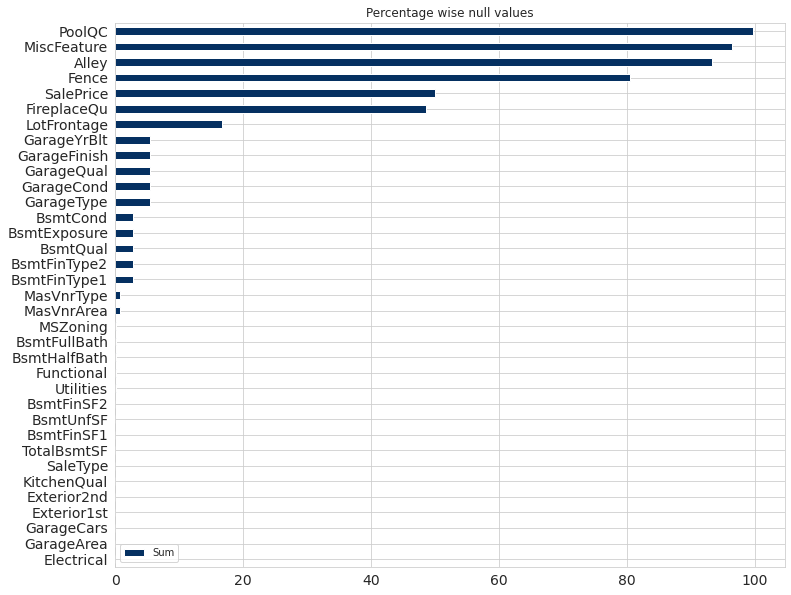

In [ ]:
## Get the dataframe with all the features and SUM of the NaN values present
df_null_count = all_data.isnull().sum().to_frame().rename({0:"Sum"}, axis=1)

## Select only those features who have atleast 1 NaN value
df_null_count = df_null_count[df_null_count['Sum'] > 0]

## Change the SUM to PERCENTAGE 
df_null_count['Sum'] = df_null_count['Sum']*(100/nindex)

## Plot a Horizontal Bar Graph
df_null_count.sort_values(by="Sum", ascending=True).plot(
    kind='barh', figsize=(12,10), fontsize=14, colormap="RdBu_r", title="Percentage wise null values"
)
plt.show()

In [ ]:
all_data['PoolQC'] = all_data['PoolQC'].fillna('None')

quality_map = {
    "None": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4
}

all_data['PoolQC'].replace(quality_map, inplace=True)


In [ ]:
all_data['MiscFeature'] = all_data['MiscFeature'].fillna('None')

In [ ]:
all_data['Alley'] = all_data['Alley'].fillna('None')

In [ ]:
all_data['Fence'] = all_data['Fence'].fillna('None')

In [ ]:
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('None')

quality_map = {
    "None": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5
}

all_data['FireplaceQu'].replace(quality_map, inplace=True)


Skewness value: 1.50


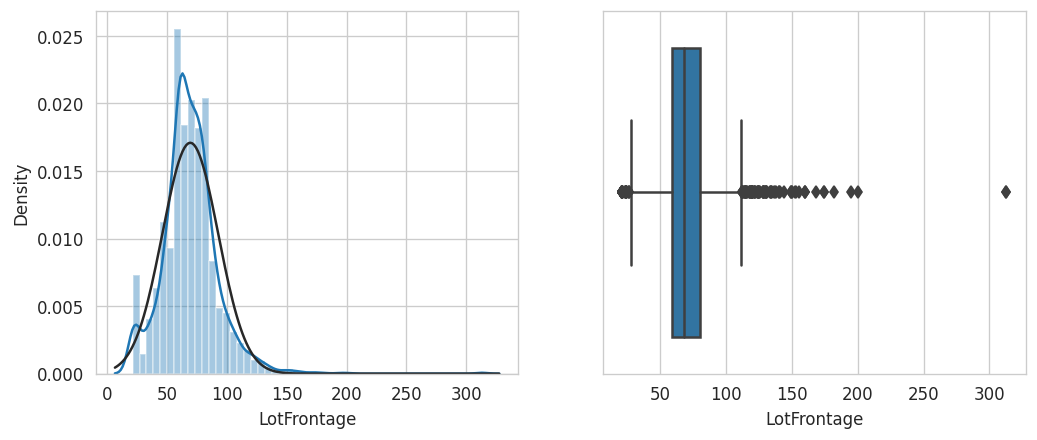

In [ ]:
from scipy.stats import norm, skew

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

sns.distplot(all_data['LotFrontage'].dropna(), fit=norm, ax=ax1)
sns.boxplot(all_data['LotFrontage'].dropna(), ax=ax2, orient='v')

print(f"Skewness value: %.2f" %all_data['LotFrontage'].dropna().skew())



In [ ]:
all_data['LotFrontage'].fillna(value=all_data['LotFrontage'].median(), inplace=True)

In [ ]:
df_no_garage = all_data[[
    'GarageYrBlt', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageCars', 'GarageArea'
]][
    all_data['GarageType'].isnull()
]

df_no_garage.head(5)

,GarageYrBlt,GarageCond,GarageFinish,GarageQual,GarageType,GarageCars,GarageArea
39,NaN,NaN,NaN,NaN,NaN,0.0,0.0
48,NaN,NaN,NaN,NaN,NaN,0.0,0.0
78,NaN,NaN,NaN,NaN,NaN,0.0,0.0
88,NaN,NaN,NaN,NaN,NaN,0.0,0.0
89,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [ ]:
for feature in ['GarageCond', 'GarageFinish', 'GarageQual', 'GarageType']:
    all_data[feature].fillna(value='None', inplace=True)
    
for feature in ['GarageYrBlt', 'GarageCars', 'GarageArea']:
    all_data[feature].fillna(value=0, inplace=True)


In [ ]:
#all_data['GarageYrBlt'] = all_data['GarageYrBlt'].astype(str)

quality_map = {
    "None": 0, "Po": 1,"Fa": 2, "TA": 3, "Gd": 4, "Ex": 5
}

all_data['GarageQual'].replace(quality_map, inplace=True)
all_data['GarageCond'].replace(quality_map, inplace=True)

quality_map = {
    "None": 0, "Unf": 1, "RFn": 2, "Fin": 3
}

all_data['GarageFinish'].replace(quality_map, inplace=True)

In [ ]:
no_basement_df = all_data[[
    'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtFinSF1', 
    'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'TotalBsmtSF'
]][
    all_data['BsmtQual'].isnull()
]

no_basement_df.head(5)



,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,TotalBsmtSF
17,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
39,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
90,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
102,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
156,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print(f"Total number of entries with Null Basement Cond are {len(no_basement_df.index)}.")


Total number of entries with Null Basement Cond are 81.


In [ ]:
for feature in ['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual']:
    all_data[feature].fillna(value='None', inplace=True)
    
for feature in ['BsmtFinSF1', 'BsmtFinSF2','BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'TotalBsmtSF']:
    all_data[feature].fillna(value=0, inplace=True)


In [ ]:
''' BsmtCond and BsmtQual '''

quality_map = {
    "None": 0, "Po": 1,"Fa": 2, "TA": 3, "Gd": 4, "Ex": 5
}

all_data['BsmtCond'].replace(quality_map, inplace=True)
all_data['BsmtQual'].replace(quality_map, inplace=True)

''' BsmtExposure '''

quality_map = {
    "None": 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4
}

all_data['BsmtExposure'].replace(quality_map, inplace=True)

''' BsmtFinType1 and BsmtFinType2 '''

quality_map = {
    "None": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6
}

all_data['BsmtFinType1'].replace(quality_map, inplace=True)
all_data['BsmtFinType2'].replace(quality_map, inplace=True)


In [ ]:
mode_val = all_data.MasVnrType.value_counts().idxmax()    # 'None'
all_data['MasVnrType'].fillna(mode_val, inplace=True) 

median_val = all_data.MasVnrArea.median()     # 0
all_data['MasVnrArea'].fillna(median_val, inplace=True)

In [ ]:
mode_val = all_data.MSZoning.value_counts().idxmax()    # 'RL'
all_data['MSZoning'].fillna(mode_val, inplace=True)

all_data['MSZoning'].replace({'C (all)': 'C'}, inplace=True)


In [ ]:
all_data.drop('Utilities', inplace=True, axis=1)

In [ ]:
mode_val = all_data.Functional.value_counts().idxmax()    #'Typ'
all_data['Functional'].fillna(mode_val, inplace=True)


In [ ]:
all_data.Exterior1st.fillna(value='Other', inplace=True)
all_data.Exterior2nd.fillna(value='Other', inplace=True)


In [ ]:
all_data.SaleType.fillna(value='Other', inplace=True)

In [ ]:
mode_val = all_data.Electrical.value_counts().idxmax()    # 'SBrkr'
all_data['Electrical'].fillna(mode_val, inplace=True) 


In [ ]:
mode_val = all_data.KitchenQual.value_counts().idxmax()    # 'TA'
all_data['KitchenQual'].fillna(value=mode_val, inplace=True)

quality_map = {
    "Po": 0,"Fa": 1, "TA": 2, "Gd": 3, "Ex": 4
}
all_data['KitchenQual'].replace(quality_map, inplace=True)

In [ ]:
id_copy = all_data['Id']
all_data.drop('Id', axis=1, inplace=True)


In [ ]:
''' Street '''
all_data['Street'].replace({'Grvl': 0, 'Pave': 1}, inplace=True)

''' CentralAir '''
all_data['CentralAir'].replace({'Y': 1, 'N': 0}, inplace=True)

''' HeatingQC | ExterQual | ExterCond'''
quality_map = {
    "Po": 0,"Fa": 1, "TA": 2, "Gd": 3, "Ex": 4
}
all_data.HeatingQC.replace(quality_map, inplace=True)
all_data.ExterQual.replace(quality_map, inplace=True)
all_data.ExterCond.replace(quality_map, inplace=True)

''' LandSlope '''
quality_map = { 'Sev': 0, 'Mod': 1, 'Gtl': 2 }
all_data.LandSlope.replace(quality_map, inplace=True)

''' LotShape '''
quality_map = { 'IR3': 0, 'IR2': 1, 'IR1': 2, 'Reg': 3 }
all_data.LotShape.replace(quality_map, inplace=True)

''' MSSubClass '''
class_map = {
    20:'Class1', 30:'Class2', 40:'Class3', 45:'Class4', 50:'Class5', 60:'Class6', 
    70:'Class7', 75:'Class8', 80:'Class9', 85:'Class10', 90:'Class11', 120:'Class12',
    150:'Class13', 160:'Class14', 180:'Class15', 190:'Class16'
}
all_data.MSSubClass.replace(class_map, inplace=True)

In [ ]:
'''
    Usually we rely more on the total area of the house rather than talking about individual areas.
    Create a new feature which sums up all the area parameters to give us the total area available in the house.
'''
all_data['TotalSF'] = all_data['1stFlrSF'] + all_data['2ndFlrSF'] + all_data['GrLivArea'] + all_data['TotalBsmtSF']

'''
    The Year features do not provide much information. We can rather work on getting more concrete information like
    No. of Years ie Age instead of actual year.
'''
## Age of the house at the time of buying
all_data['Age'] = all_data.YrSold - all_data.YearBuilt

## No. of years since the house was remodeled at the time of buying
all_data['AgeRemod'] = all_data.YrSold - all_data.YearRemodAdd

## No. of years since the Garage was built at the time of buying
'''
    For the houses without garages we have already impted them with 0.0
    So, before building the new feature  we will replace them with the corresponding values in YrSold.
    This will ensure that the AgeGarage feature will be 0 for the houses that do not have Garage.
    If we do not perform the above operation then we will get an Age which is ~ 2000.
'''
all_data['GarageYrBlt'].replace({0.0: np.nan}, inplace=True)
all_data['GarageYrBlt'].fillna(all_data['YrSold'], inplace=True)
all_data['AgeGarage'] = all_data.YrSold - all_data.GarageYrBlt

In [ ]:
all_data.Age       =  all_data.Age.map(lambda x: 0 if x < 0 else x)
all_data.AgeRemod  =  all_data.AgeRemod.map(lambda x: 0 if x < 0 else x)
all_data.AgeGarage =  all_data.AgeGarage.map(lambda x: 0 if x < 0 else x)

all_data.drop(
    ['YrSold','YearBuilt','YearRemodAdd','GarageYrBlt', 'MoSold'], 
    axis=1, inplace=True
)


In [ ]:
def plot_numeric_features(feature):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi=110)

    sns.distplot(all_data[feature], ax=ax1)
    sns.scatterplot(all_data[feature], all_data["SalePrice"], ax=ax2)
    sns.boxplot(all_data[feature], ax=ax3, orient='v', width=0.2)

    print("Skewness Coefficient of LotFrontage is %.2f" %all_data[feature].skew())
    ax1.set_yticks([])
    
    return plt

Skewness Coefficient of LotFrontage is 1.68


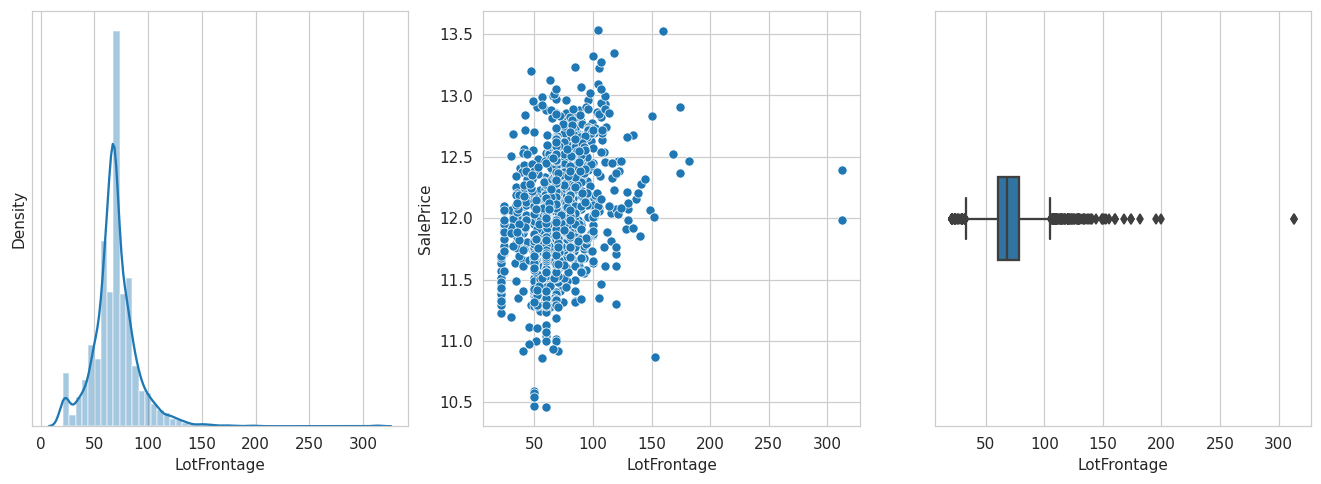

In [ ]:
plot_numeric_features("LotFrontage").show()

In [ ]:
drop_index = all_data['LotFrontage'][all_data['LotFrontage'] > 300].index

Skewness Coefficient of LotFrontage is 12.83


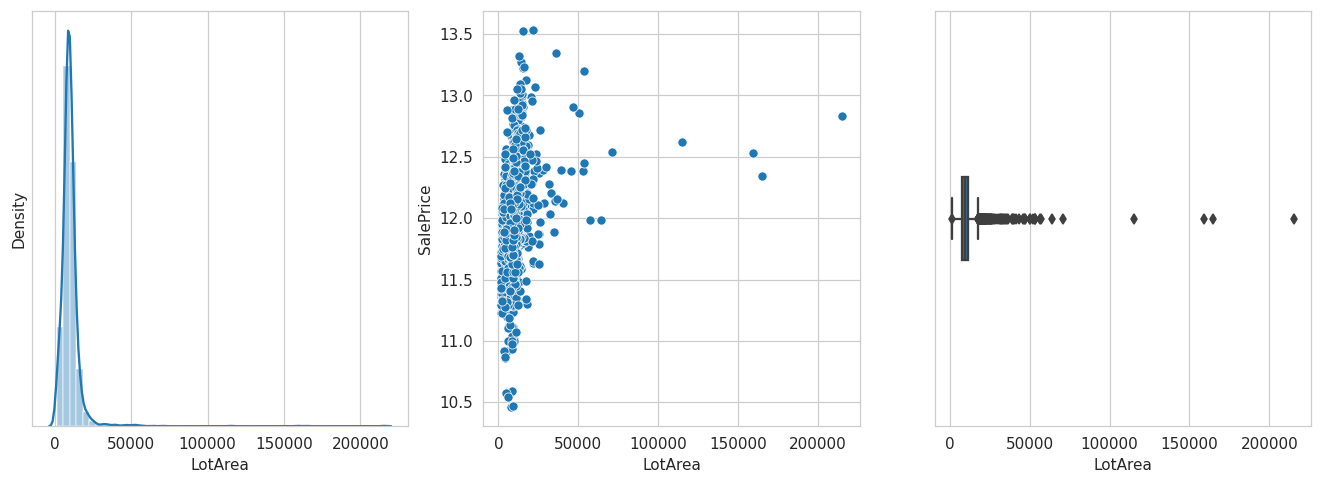

In [ ]:
plot_numeric_features("LotArea").show()

In [ ]:
drop_index = np.append(drop_index, all_data['LotArea'][all_data['LotArea'] > 100000].index)

Skewness Coefficient of LotFrontage is 1.43


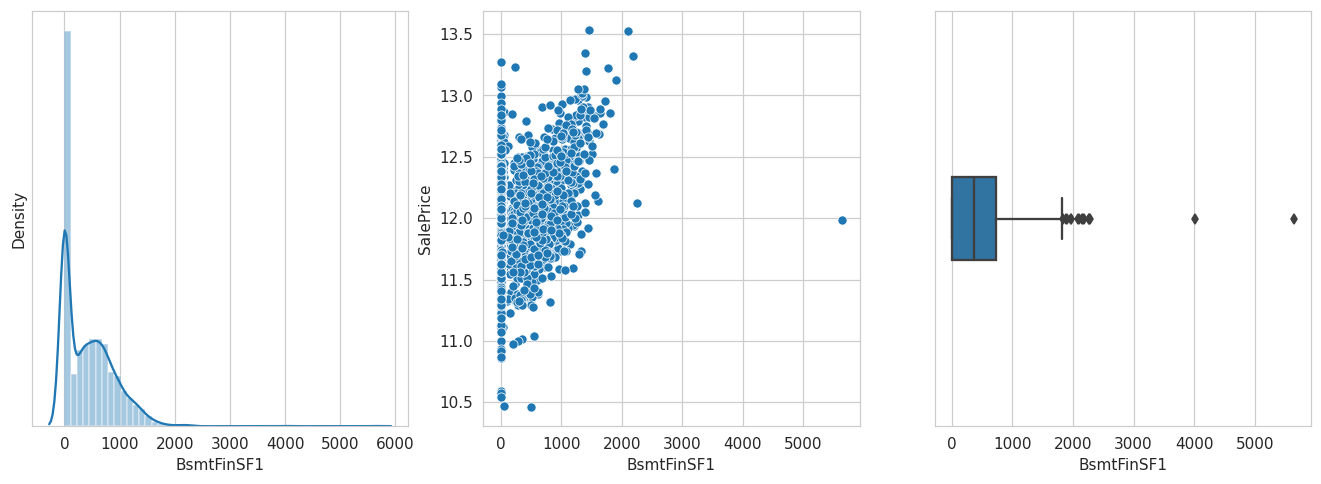

In [ ]:
plot_numeric_features("BsmtFinSF1").show()

In [ ]:
drop_index = np.append(drop_index, all_data['BsmtFinSF1'][all_data['BsmtFinSF1'] > 5000].index)

Skewness Coefficient of LotFrontage is 1.16


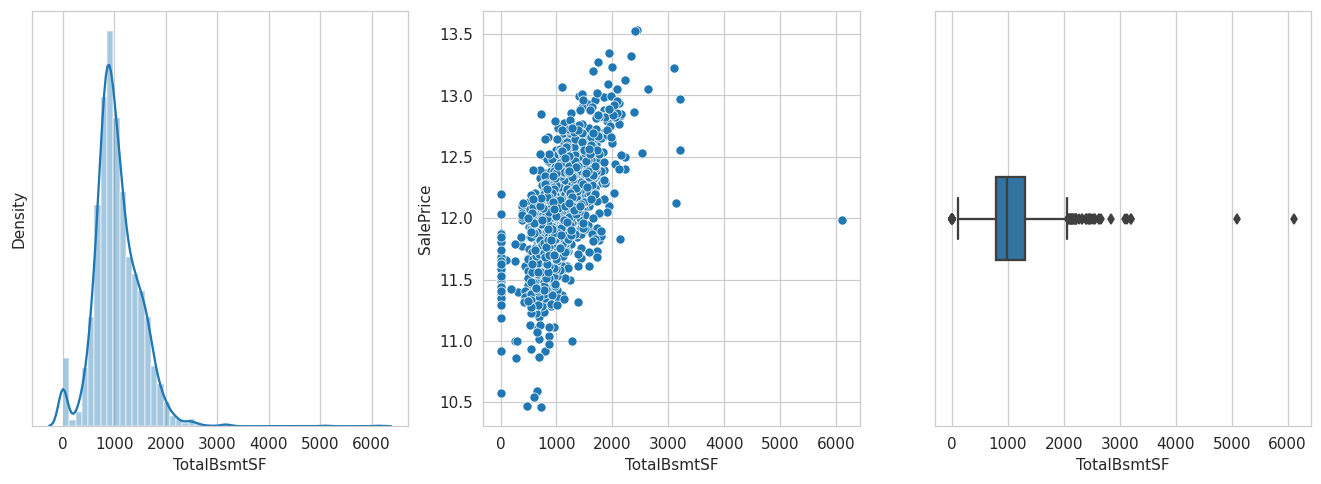

In [ ]:
plot_numeric_features("TotalBsmtSF").show()

In [ ]:
drop_index = np.append(drop_index, all_data['TotalBsmtSF'][all_data['TotalBsmtSF'] > 6000].index)

Skewness Coefficient of LotFrontage is 1.47


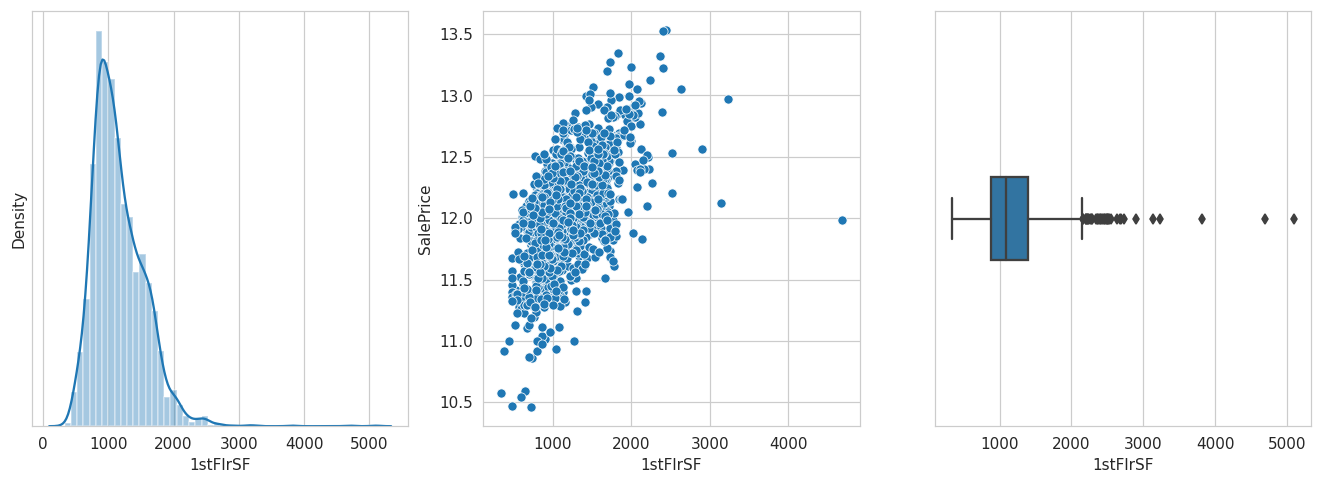

In [ ]:
plot_numeric_features("1stFlrSF").show()

In [ ]:
drop_index = np.append(drop_index, all_data['1stFlrSF'][all_data['1stFlrSF'] > 4000].index)

Skewness Coefficient of LotFrontage is 1.27


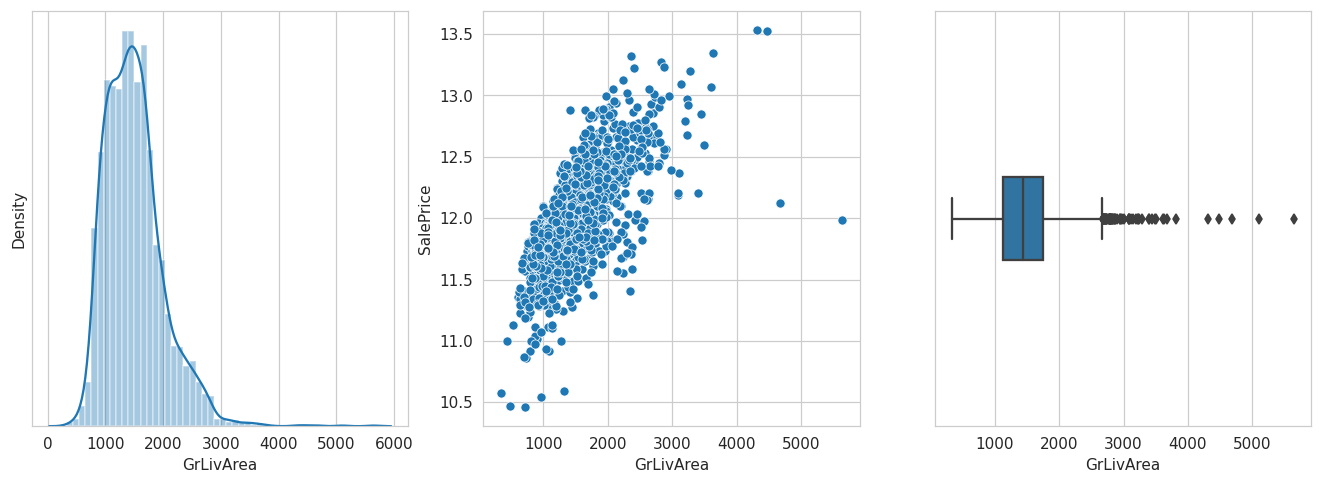

In [ ]:
plot_numeric_features("GrLivArea").show()

In [ ]:
drop_index = np.append(drop_index, all_data['GrLivArea'][
    (all_data['GrLivArea'] > 4000) & (all_data['SalePrice'] < 12.5)
].index)


In [ ]:
## Making sure we only remove data from the train set
drop_index = drop_index[drop_index < ntrain]

all_data = all_data.drop(drop_index).reset_index(drop=True)

## Length of indexes dropped
dropped_count = len(drop_index)

## Modify our ntrain variable
ntrain -= dropped_count

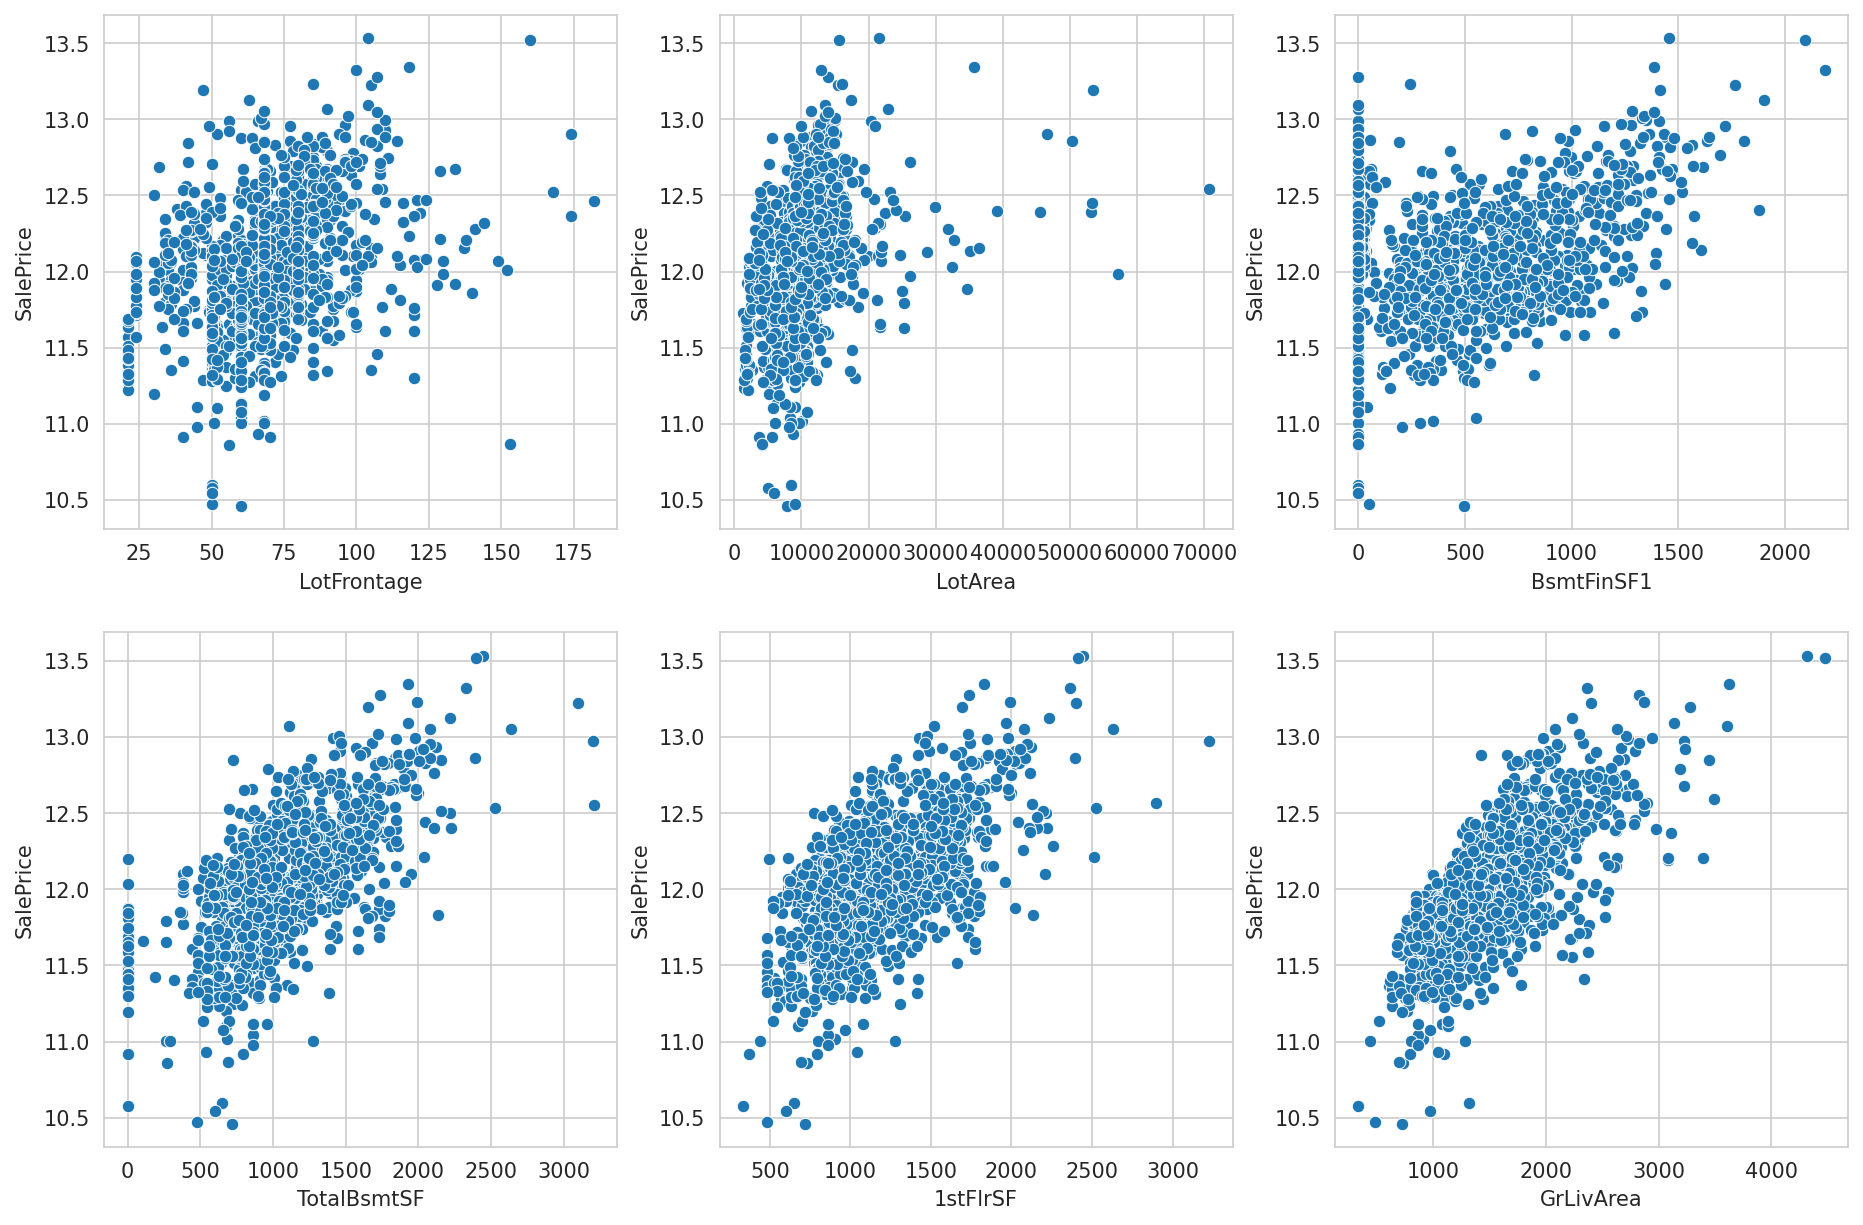

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10), dpi=150)

def create_scatter_plot(feature, axis):
    sns.scatterplot(all_data[feature], all_data["SalePrice"], ax=axis)
    
create_scatter_plot('LotFrontage', ax1)
create_scatter_plot('LotArea', ax2)
create_scatter_plot('BsmtFinSF1', ax3)
create_scatter_plot('TotalBsmtSF', ax4)
create_scatter_plot('1stFlrSF', ax5)
create_scatter_plot('GrLivArea', ax6)

plt.show()

In [ ]:
## Get all the numeric features in out dataset
numeric_features = all_data.skew().index

## Getting all the skewed features (skew > 0.5 or skew < -0.5)
skewed_features = all_data[numeric_features].skew()[np.abs(all_data[numeric_features].skew()) > 0.5].index

## Performing log(1+x) transformation
all_data[skewed_features] = np.log1p(all_data[skewed_features])

In [ ]:
## Get all the categorical columns
cat_cols = all_data.select_dtypes("object").columns

## One-Hot Encoding all the categorical variables but dropping one of the features among them.
drop_categ = []
for i in cat_cols:
    drop_categ += [ i+'_'+str(all_data[i].unique()[-1]) ]

## Create dummy variables (One-Hot Encoding)
all_data = pd.get_dummies(all_data, columns=cat_cols) 

## Drop the last column generated from each categorical feature
all_data.drop(drop_categ, axis=1, inplace=True)

In [ ]:
X_train =  all_data[:-ntest].drop(['SalePrice'], axis=1)
y_train =  all_data[:-ntest]['SalePrice']
X_test  =  all_data[-ntest:].drop(['SalePrice'], axis=1)

## Remove SalePrice from numeric_features to avoid scaling it
numeric_features = numeric_features.drop('SalePrice')

## Scaling all the numeric features using Robust Scaler
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features]  = scaler.transform(X_test[numeric_features])


In [ ]:
X_train.columns

Index(['LotFrontage', 'LotArea', 'Street', 'LotShape', 'LandSlope',
       'OverallQual', 'OverallCond', 'MasVnrArea', 'ExterQual', 'ExterCond',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=224)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow_addons.layers import WeightNormalization
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras import metrics

model = 'NN'

def NN_model():
    horsepower = np.array(X_train)
    horsepower_normalizer = preprocessing.Normalization(input_shape=[X_train.shape[1],])
    horsepower_normalizer.adapt(horsepower)

    horsepower_model = tf.keras.Sequential([
        horsepower_normalizer,
        WeightNormalization(layers.Dense(units=8 , activation='linear')),
        layers.BatchNormalization(),
        layers.Dense(units=1, activation='linear')
    ])

    horsepower_model.summary()

    METRICS = [
        metrics.MeanSquaredError(),

    ]

    horsepower_model.compile(
                        optimizer=tf.optimizers.Adam(learning_rate=0.1),
                        loss='mse',
                        metrics=METRICS)
    
    return horsepower_model
if model == 'linear':
    reg = LinearRegression().fit(Train.drop('SalePrice_log', axis = 1), Train[['SalePrice_log']])
    predict = reg.predict(Test)
elif model == 'NN':
    nn_model = NN_model()
    filepath="best_weights.hdf5"
    Monitor = 'loss'
    checkpoint = ModelCheckpoint(filepath, monitor=Monitor, verbose=1, save_best_only=True, mode='min')
    nn_model.fit(X_train, y_train, epochs = 1000,callbacks = [checkpoint])
    from keras.models import load_model
    nn_model = load_model('best_weights.hdf5')
    predict = nn_model.predict(X_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 224)               449       
_________________________________________________________________
weight_normalization (Weight (None, 8)                 3609      
_________________________________________________________________
batch_normalization (BatchNo (None, 8)                 32        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 4,099
Trainable params: 1,833
Non-trainable params: 2,266
_________________________________________________________________
Epoch 1/1000
42/46 [==========================>...] - ETA: 0s - loss: 25.3403 - mean_squared_error: 25.3403
Epoch 00001: loss improved from inf to 23.51921, saving model to best_weights.hdf5
46/46 [==============================] - 0s 3ms/step - lo

In [ ]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [ ]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)


In [ ]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [ ]:


ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))



In [ ]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [ ]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)



In [ ]:


model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)



In [ ]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)


In [ ]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))



Lasso score: 0.1117 (0.0060)



In [ ]:


score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))



ElasticNet score: 0.1118 (0.0061)



In [ ]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1128 (0.0055)



In [ ]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1151 (0.0070)



In [ ]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Xgboost score: 0.1145 (0.0063)



In [ ]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


LGBM score: 0.1150 (0.0055)



In [ ]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   


In [ ]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


 Averaged base models score: 0.1085 (0.0061)



In [ ]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
        
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)


In [ ]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))


Stacking Averaged models score: nan (nan)


In [ ]:


def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))



In [ ]:
stacked_averaged_models.fit(X_train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(X_train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(X_test.values))
print(rmsle(y_train, stacked_train_pred))


0.08059148637333528


In [ ]:
model_xgb.fit(X_train, y_train)
xgb_train_pred = model_xgb.predict(X_train)
xgb_pred = np.expm1(model_xgb.predict(X_test))
print(rmsle(y_train, xgb_train_pred))

0.07990608654519096


In [ ]:
model_lgb.fit(X_train, y_train)
lgb_train_pred = model_lgb.predict(X_train)
lgb_pred = np.expm1(model_lgb.predict(X_test.values))
print(rmsle(y_train, lgb_train_pred))


0.07281517224655683


In [ ]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))


RMSLE score on train data:
0.0771751046253459


In [ ]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

In [ ]:
sub = pd.DataFrame()
sub['Id'] = test['Id']
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)


In [ ]:
from xgboost import XGBRegressor
xgb = XGBRegressor()

xgb.fit(X_train, y_train)
df_imp = pd.DataFrame(xgb.feature_importances_ , columns = ['Importance'], index=X_train.columns)
df_imp = df_imp.sort_values(['Importance'], ascending = False)

df_imp.head()



[21:30:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,Importance
ExterQual,0.296839
GarageFinish,0.131651
GarageCars,0.074324
FireplaceQu,0.070875
KitchenQual,0.059247


In [ ]:
from xgboost import XGBRegressor
xgb = XGBRegressor()

xgb.fit(X_train, y_train)
df_imp = pd.DataFrame(xgb.feature_importances_ , columns = ['Importance'], index=X_train.columns)
df_imp = df_imp.sort_values(['Importance'], ascending = False)

df_imp.head()



[22:00:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,Importance
ExterQual,0.296839
GarageFinish,0.131651
GarageCars,0.074324
FireplaceQu,0.070875
KitchenQual,0.059247


In [ ]:
## Function to calculate RMSE
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true-y_pred)**2))

## Function to calculate negative RMSE
def nrmse(y_true, y_pred):
    return -1.0*rmse(y_true, y_pred)

from sklearn.metrics import make_scorer
neg_rmse = make_scorer(nrmse)

from xgboost import XGBRegressor
estimator = XGBRegressor()

from sklearn.feature_selection import RFECV
estimates = RFECV(estimator, cv = 3, n_jobs = -1, scoring = neg_rmse)
estimates = estimates.fit(X_train, y_train)

print(f"No. of highly important features: {estimates.n_features_}")

## List of important features
imp_features = X_train.columns.values[estimates.support_]

X_train =  X_train[imp_features]
X_test  =  X_test[imp_features]


[22:02:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:02:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:02:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:02:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:02:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:02:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:02:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:02:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
from sklearn.kernel_ridge import KernelRidge
ridge = KernelRidge()

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
parameters = {
    'alpha': uniform(0.05, 1.0), 'kernel': ['polynomial'], 'degree': [2], 'coef0': uniform(0.5, 3.5)
}

random_search = RandomizedSearchCV(
    estimator = ridge, param_distributions = parameters, n_iter = 1000, 
    cv = 3, scoring = neg_rmse, n_jobs = -1, random_state=0
)

random_search = random_search.fit(X_train, y_train)

model = random_search.best_estimator_

print(f"Training RMSE: {round(rmse(y_train, model.predict(X_train)), 3)}")


Training RMSE: 0.095


In [ ]:
## Inverse Transforming log transformed SalePrice (y_pred)
y_pred = np.exp(model.predict(X_test))

## Final DataFrame consisting of the SalePrice
output = pd.DataFrame({'Id': test['Id'], 'SalePrice': y_pred})

output.to_csv('prediction.csv', index=False)